In [4]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
import seaborn as sns
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import geopandas
import shapely.geometry

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial
from plotter import draw_basemap, plot_terrain


pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [5]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [6]:
## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection

HUC8_ID_lst = [14050005, ## upper white
               # 14050002, ## lower yampa
               # 14080104, ## animas (San Juans),
               14030002, ## upper dolores
               11020002, ## arkansas - Pueblo Reservoir
               10190005 ## St. Vrain (Boulder)
              ]
polys_lst = []
for i, HUC8_ID in enumerate(HUC8_ID_lst):
    idx = (polys.HUC8 == str(HUC8_ID_lst[i]))
    tmp =  polys[idx]
    polys_lst.append(tmp)


In [7]:
HUC8_lbls = ['Upper White', 'Upper Dolores', 'Arkansas', 'St. Vrain']

In [8]:

cell_lst = []
for i, HUC8_ID in enumerate(HUC8_ID_lst):
    fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ERA5 = xr.open_dataset(fname)
    
    ## open as geopandas dataframe
    df = ERA5.to_dataframe()
    gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

    ### Code is based on https://james-brennan.github.io/posts/fast_gridding_geopandas/

    ### BUILD A GRID 
    # total area for the grid
    xmin, ymin, xmax, ymax= gdf.total_bounds
    # how many cells across and down
    n_cells=100
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "EPSG:4326"
    # create the cells in a loop
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
    cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], 
                                     crs=crs)

    merged = geopandas.sjoin(gdf, cell, how='left', predicate='within')

    # make a simple count variable that we can sum
    merged['n_traj']=1
    # Compute stats per grid cell -- aggregate fires to grid cells with dissolve
    dissolve = merged.dissolve(by="index_right", aggfunc="count")
    # put this into cell
    cell.loc[dissolve.index, 'n_traj'] = dissolve.n_traj.values
    cell_lst.append(cell)

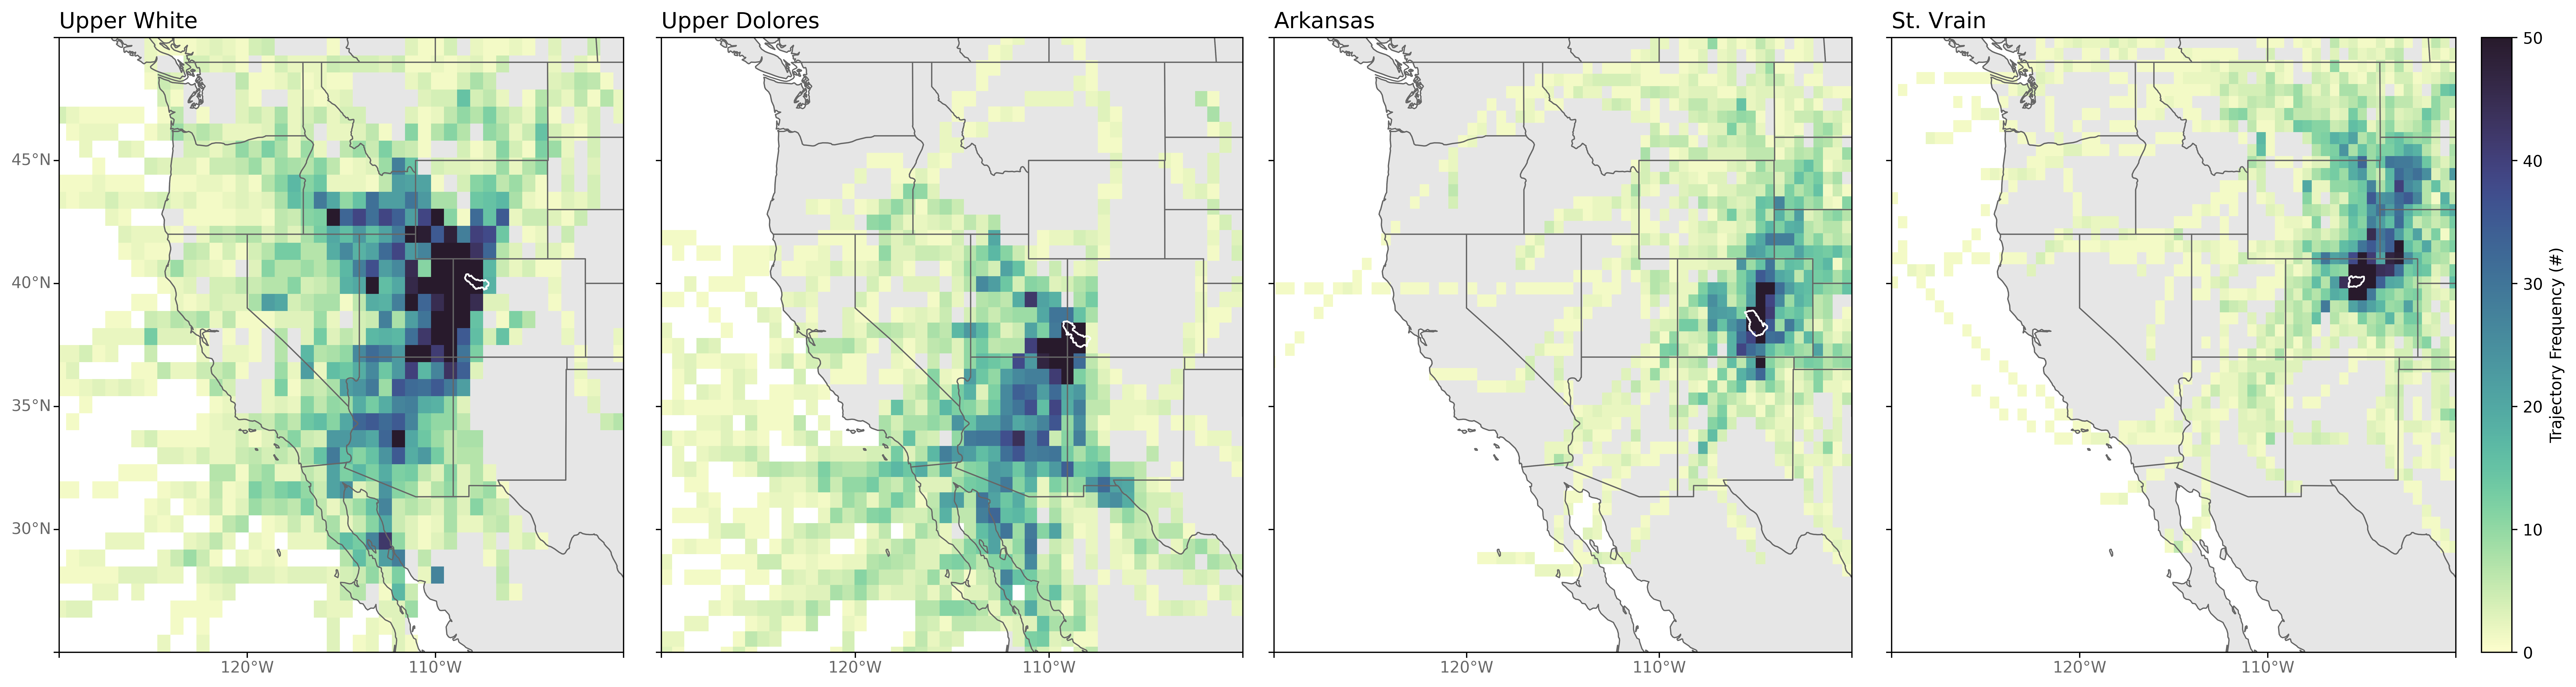

In [12]:
ext = [-130., -100., 25., 50.] 
fmt = 'png'

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

nrows = 1
ncols = 5

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 1, 1, 1, 0.05], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(28.0 ,7.0))
fig.dpi = 600
fname = path_to_figs + 'heatmaps'

# Add color bar axis
cbax = plt.subplot(gs[:,-1]) # colorbar axis

row_idx = [0, 0, 0, 0]
col_idx = [0, 1, 2, 3]
llat_lst = [True, False, False, False]
for i, cell in enumerate(cell_lst):
    ax = fig.add_subplot(gs[row_idx[i],col_idx[i]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=llat_lst[i], right_lats=False)
    ax.set_extent(ext, datacrs)

    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    ax.set_title(HUC8_lbls[i], loc='left', fontsize=14)

    ## plotting based off of https://geopandas.org/en/stable/docs/user_guide/mapping.html
    cf = cell.plot(ax=ax, column='n_traj', cmap=cmo.deep, vmin=0, vmax=50, edgecolor=None, legend=True, cax=cbax,
                  legend_kwds={"label": "Trajectory Frequency (#)", "orientation": "vertical"})
# cf = ax.add_geometries(cell['geometry'], crs=ccrs.epsg('4326'), cmap=cmo.deep, vmax=50, edgecolor=None)

    ## add in four focus watersheds
    polys_lst[i].plot(ax=ax, edgecolor='white', color='None', zorder=99)


# cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
# cb.set_label('Trajectory Frequency (#)', fontsize=11)
# cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()